## Q-learning with ORF

**Algorithm: Q-learning with shallow function approximator**

---

Initialize replay memory D to capacity N

Initialize action-value function Q with random weights

**for** episode = 1 to M **do**

&nbsp;&nbsp;&nbsp;&nbsp; Initialize sequence $s_{1} = \{x_{1}\}$ and preprocessed sequence $\phi_{1} = \phi(s_{1})$

&nbsp;&nbsp;&nbsp;&nbsp; **for** t = 1 to T **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $a_{t} = \begin{cases} \max_{a}Q(\phi(s_{t}), a; \theta)&\text{with probability } 1-\epsilon \\ \text{random action }&\text{with probability } \epsilon \end{cases}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Execute action $a_{t}$ and observe reward $r_{t}$ and image $x_{t+1}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $s_{t+1}=s_{t}$, and preprocess $\phi_{t+1} = \phi(s_{t+1})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Store transition ($\phi_{t}, a_{t}, r_{t}, \phi_{t+1}$) in D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample random minibatch of transitions ($\phi_{j}, a_{j}, r_{j}, \phi_{j+1}$) from D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y_{j} = \begin{cases} r_{j}&\text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'} Q(\phi_{j+1}, a'; \theta)&\text{for non-terminal } \phi_{j+1} \end{cases}$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fit the approximator with ($\phi_{j}$,  $y_{j}$)

&nbsp;&nbsp;&nbsp;&nbsp; **end for**

**end for**

---

s = state, 

a = current action, 

a' = action for the next state, 

$\theta$ = parameters for the function approximator, 

$Q(s,a;\theta)$: action-value function estimated by a function approximator



In [ ]:
# Changes in v3: 
# Expand number of trees to maxTrees at episode = 100


In [1]:
import gym
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
# import os.path
# import copy
import numpy as np
import time
import datetime
import sys
# import multiprocessing
# from cProfile import Profile

In [ ]:
# On Google Colab
# # -------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
sys.path.insert(0, '/content/drive/My\ Drive/Colab\ Notebooks/')
# # --------------------------------------------------------------------------
!pip install box2d-py
%cd /content/drive/My\ Drive/Colab\ Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
# !python setup_ORF.py build_ext --inplace

Compiling ORF_cython.pyx because it changed.
[1/1] Cythonizing ORF_cython.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Colab Notebooks/ORF_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'ORF_cython' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c ORF_cython.c -o build/temp.linux-x86_64-3.6/ORF_cython.o
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.6/ORF_cython.o -o /content/drive/My Drive/Colab Notebooks/ORF_

In [ ]:
# !python setup_DQN.py build_ext --inplace

Compiling DQN.pyx because it changed.
[1/1] Cythonizing DQN.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Colab Notebooks/DQN.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'DQN' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c DQN.c -o build/temp.linux-x86_64-3.6/DQN.o
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.6/DQN.o -o /content/drive/My Drive/Colab Notebooks/DQN.cpython-36m-x86_64-linux-gnu.so


In [ ]:
# !cython -a ORF_cython.pyx
# !cython -a DQN.pyx
# import ORF_cython as ORF
# import DQN

/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Colab Notebooks/ORF_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [2]:
# On Google Colab
# # -------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Colab\ Notebooks/TreeRL/
!ls
import sys
sys.path.insert(0, '/content/drive/My\ Drive/Colab\ Notebooks/TreeRL/')
# # --------------------------------------------------------------------------
import ORF

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/TreeRL
ORF_CartPole_200922_1.jpg  ORF_CartPole_200923_1.p  __pycache__
ORF_CartPole_200922_1.p    ORF_CartPole_v3.ipynb
ORF_CartPole_200923_1.jpg  ORF.py


In [3]:
class ORF_DQN(): 
    
    def __init__(self, n_state, n_action, replay_size, ORFparams):
        self.n_action = n_action
        self.a_model = {} # to build RF for each action
        self.a_params = {a: ORFparams for a in range(n_action)}
        self.isFit = False
        self.maxTrees = ORFparams['maxTrees']
    
    def predict(self, s):            
        # s: (4,) array (for cartpole)
        
        preds = [self.a_model[a].predict(s) for a in range(self.n_action)]
        # print(preds)
        return preds

    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        
        def policy_function(state):
            # state: (4,) array
            ran = "_"
            q_values =[0.0, 0.0]
            if np.random.uniform(0,1) < epsilon:
                ran = "Random"
                return([random.randint(0, n_action - 1), ran, q_values])
            else:
                if self.isFit == True:
                    ran = "Model"
                    q_values = self.predict(state) # (1,2) array
                    # print(q_values)
                else: 
                    ran = "Random_notFit"
                    return([random.randint(0, n_action - 1), ran, q_values])
                    # print("passed random.randint")
            return([np.argmax(q_values), ran, q_values])# int
        
        return policy_function


    # def expandForest(self, memory):
    #     for a in range(self.n_action):
    #         self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
    #         lenFor = len(self.a_model[a].forest)
    #         for i in range(lenFor+1, self.maxTrees):
    #             self.a_model[a].forest[i] = ORF.ORT(self.a_params[a]) # build new empty trees
    

    def replay(self, memory, replay_size, gamma, episode):
        
        if len(memory) == replay_size: # Build initial Forests
            
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                self.a_model[a] = ORF.ORF(self.a_params[a]) # Fit initial RFs for each action            

        if len(memory) >= replay_size: # When the memory size exceeds the replay_size, start updating the RFs            
            
            replay_data = random.sample(memory, replay_size) # replay_data consists of [state, action, next_state, reward, is_done]
            for state, action, next_state, reward, is_done in replay_data:
                
                q_values = self.predict(state) # (, n_actions)
                q_values[action] = reward + gamma * np.max(self.predict(next_state)) if is_done == False else 1000 * reward
                
                # Update the RF for the action taken
                xrng = ORF.dataRange([v[0] for v in replay_data if v[1] == action])
                self.a_model[action].update(state, q_values[action], xrng)    
            self.isFit = True
               
        if episode == 100: # expand the number of trees at episode 100            
            # expandForest(memory)
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                lenFor = len(self.a_model[a].forest)
                for i in range(lenFor+1, self.maxTrees):
                    self.a_model[a].forest[i] = ORF.ORT(self.a_params[a]) # build new empty trees

            
            

In [4]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.95):
    
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False
        i = 0
        while not is_done:
            action, ran, pred = policy(state) # integer
            next_state, reward, is_done, _ = env.step(action)
            i += 1
            # next_state: 4x1 array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)
            
            total_reward_episode[episode] += reward
            
            # ep[episode].append((i, state, ran, action))
            memory.append((state, action, next_state, reward, is_done))
            
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma, episode)
            state = next_state
        epsilon = np.max([epsilon * epsilon_decay, 0.01])
        # print(epsilon)

In [5]:
# Initialization
env = gym.envs.make("LunarLander-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
memory = deque(maxlen=10000)
n_episode = 200
replay_size = 32

ORFparams = {'minSamples': replay_size*2, 'minGain': 0.1, 'xrng': None, 'maxDepth': 15, 'numTrees': 5, 'maxTrees': 30} # numTrees -> 30 after 100 iters. 25 restarts

dqn = ORF_DQN(n_state, n_action, replay_size, ORFparams) 

total_reward_episode = np.zeros(n_episode)

ep = {i: [] for i in range(n_episode)}

QLparams = {'gamma' : 1.0, 'epsilon' : 0.5, 'epsilon_decay' : 0.99}

In [6]:
# Run alg

start = time.time()

q_learning(env, dqn, n_episode, replay_size, gamma=QLparams['gamma'], epsilon=QLparams['epsilon'], epsilon_decay=QLparams['epsilon_decay']) # runs the alg

end = time.time()

duration = int(end - start)

print("learning duration =", duration, " seconds")
print("mean reward = ", np.mean(total_reward_episode))
print("max reward = ", max(total_reward_episode))



  6%|▌         | 12/200 [02:30<1:12:57, 23.29s/it]

KeyboardInterrupt: ignored

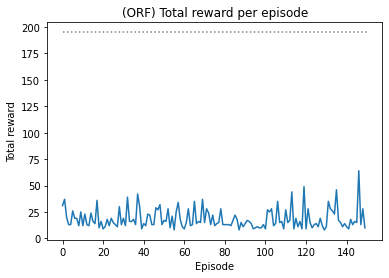

<Figure size 432x288 with 0 Axes>

In [ ]:
backup_file_name = "ORF_LunarLander_" + time.strftime("%y%m%d") + "_1"
img_file = backup_file_name + ".jpg"
plt.plot(total_reward_episode)
plt.title("(ORF) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.hlines(195, xmin=0, xmax=n_episode, linestyles="dotted", colors="gray")
plt.show()
plt.savefig(fname = img_file)

In [ ]:
# To back-up the work
backup_file = backup_file_name + ".p"
backup_check = os.path.isfile(backup_file)

myEnv = dict()
myEnv["t_r_e"] = total_reward_episode
myEnv["duration"] = duration
myEnv["episode_details"] = ep
myEnv["ORFparams"] = ORFparams
myEnv["QLparams"] = QLparams
# myEnv["ORF_params"] = params

with open(backup_file, "wb") as file:
    pickle.dump(myEnv, file)

In [ ]:
# About Cartpole
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    
    Reward:
        Reward is 1 for every step taken, including the termination step
    
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
    
    Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """


In [ ]:
import pstats
stats = pstats.Stats("profile_200913.pfl")
stats.strip_dirs()
stats.sort_stats('cumulative')
stats.print_stats()

ning)
        6    0.000    0.000    0.000    0.000 _common.py:13(tzname_in_python2)
        1    0.000    0.000    0.000    0.000 _parser.py:667(_result)
        1    0.000    0.000    0.000    0.000 _subplots.py:218(<genexpr>)
        1    0.000    0.000    0.000    0.000 GimpGradientFile.py:66(GradientFile)
        1    0.000    0.000    0.000    0.000 figure.py:154(AxesStack)
        1    0.000    0.000    0.000    0.000 PngImagePlugin.py:981(_idat)
        1    0.000    0.000    0.000    0.000 PngImagePlugin.py:992(_fdat)
        1    0.000    0.000    0.000    0.000 ImageFile.py:570(PyCodecState)
        1    0.000    0.000    0.000    0.000 _monitor.py:8(TqdmSynchronisationWarning)
        1    0.000    0.000    0.000    0.000 __init__.py:424(StrFormatStyle)
        1    0.000    0.000    0.000    0.000 __init__.py:433(StringTemplateStyle)
        1    0.000    0.000    0.000    0.000 __init__.py:674(Filter)
        1    0.000    0.000    0.000    0.000 std.py:34(TqdmTypeError)
